In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from UnarySim.sw.kernel.linear import *
import matplotlib.pyplot as plt
import time
import math

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
in_feature = 16
out_feature = 8
bias = True
bitwidth = 8
keep_res = "input"
more_res = "input"
rounding = "round"

total_bit = 16
input_int_bit = 3
input_fra_bit = total_bit - input_int_bit

input = ((torch.rand(256, in_feature) - 0.5) * 2**(2*input_int_bit)).round().div(2**(input_int_bit)).to(device)

fc = torch.nn.Linear(in_feature, out_feature, bias=bias).to(device)
fc_o = fc(input)

ufc = FxpLinear(in_feature, out_feature, bias=bias, binary_weight=fc.weight.data, binary_bias=fc.bias, bitwidth=bitwidth, keep_res=keep_res, more_res=more_res, rounding=rounding).to(device)
ufc_o = ufc(input)

(fc_o - ufc_o).abs().mean().backward()

diff max: tensor(0.0177, device='cuda:0', grad_fn=<MaxBackward1>)
diff min: tensor(-0.0262, device='cuda:0', grad_fn=<MinBackward1>)
diff mean: tensor(-6.4635e-05, device='cuda:0', grad_fn=<MeanBackward0>)


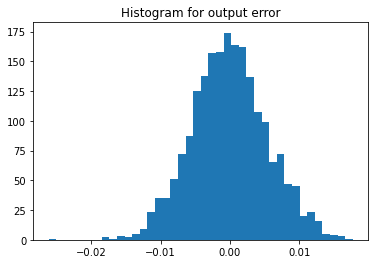

In [5]:
diff = (ufc_o - fc_o)
print("diff max:", diff.max())
print("diff min:", diff.min())
print("diff mean:", diff.mean())

fig = plt.hist(diff.cpu().detach().numpy().flatten(), bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram for output error")
plt.show()

diff grad max: tensor(0.2368, device='cuda:0')
diff grad min: tensor(-0.2273, device='cuda:0')
diff grad mean: tensor(-0.0103, device='cuda:0')


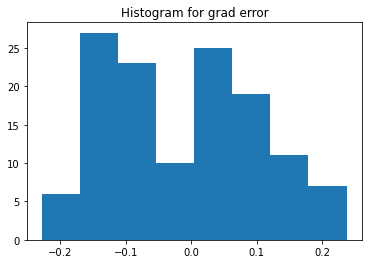

In [6]:
diff_grad = (ufc.weight.grad - fc.weight.grad)
print("diff grad max:", diff_grad.max())
print("diff grad min:", diff_grad.min())
print("diff grad mean:", diff_grad.mean())

fig = plt.hist(diff_grad.cpu().detach().numpy().flatten(), bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram for grad error")
plt.show()

In [7]:
print(ufc_o)

tensor([[-1.7186,  0.0766,  2.3008,  ..., -1.0563,  0.3886, -1.5150],
        [ 0.5675, -1.6226,  1.1828,  ..., -0.1916,  0.0214, -1.5133],
        [-0.0919,  0.9636, -1.5125,  ..., -0.2905, -0.8876,  0.3581],
        ...,
        [-0.8336, -0.1592,  1.9178,  ..., -1.5674,  1.0440,  0.8813],
        [-0.9030, -0.7242, -0.2721,  ...,  0.7154,  1.3541,  1.7112],
        [-2.1893, -0.7908,  2.0019,  ...,  1.6094, -2.0121, -0.8614]],
       device='cuda:0', grad_fn=<FxpLinearFunctionBackward>)
